## 📚 Prerequisites

Ensure that your Azure Services are properly set up, your Conda environment is created, and your environment variables are configured as per the instructions in the [SETTINGS.md](SETTINGS.md) file.

## 📋 Table of Contents

This notebook assists in conducting a comprehensive performance assessment for Azure OpenAI endpoints, focusing on the operational efficiency of the model in processing requests. The following sections are covered:

1. [**Latency Testing**](#latency-testing): This section explores how to conduct latency tests on Azure OpenAI endpoints. Latency measures the response time for a request, assessing how quickly the model responds to a specific request.

2. [**Throughput Testing**](#throughput-testing): This part details the steps to perform throughput tests on Azure OpenAI endpoints. Throughput evaluates the number of requests the model can handle in a given time frame, providing an understanding of the model's capacity and efficiency.

3. [**Analyzing Test Results**](#analyzing-test-results): This section provides guidance on how to analyze the results from the latency and throughput tests, helping you understand the performance metrics and their implications on the operational efficiency of your model.

For additional information, refer to the following resources:
- [Azure OpenAI API Documentation](https://learn.microsoft.com/en-us/azure/ai-services/openai/reference)

In [10]:
import os
from datetime import datetime

# Define the target directory
TARGET_DIRECTORY = "C:\\Users\\pablosal\\Desktop\\gbbai-azure-openai-benchmark"

# Get the current working directory
current_directory = os.getcwd()

if current_directory != TARGET_DIRECTORY:
    # Go up one directory from the current working directory
    PARENT_DIRECTORY = os.path.join(current_directory, '..', '..')
    PARENT_DIRECTORY = os.path.realpath(PARENT_DIRECTORY)

    # Change the current working directory to the parent directory
    os.chdir(PARENT_DIRECTORY)
    print(f"Directory changed to {os.getcwd()}")
else:
    print("Current directory is already the target directory.")

Current directory is already the target directory.


In [11]:
# SETUP 
MODEL = "gpt-4-turbo-2024-04-09-ptu"
REGION = "eastus2"
OAZURE_OPENAI_API_KEY = os.getenv("OPENAI_API_KEY_SWEEDENCENTRAL_PTU")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT_SWEEDENCENTRAL_PTU")
AZURE_OPENAI_API_VERSION = "2024-02-15-preview"

FILENAME = f"benchmarks/gpt-4-turbo/{REGION}/{MODEL}/"


## Run Latency Benchmarking

In [12]:
from src.performance.aoaihelpers.latencytest import (
    AzureOpenAIBenchmarkStreaming,
    AzureOpenAIBenchmarkNonStreaming,
)

In [13]:
# Define the deployment names and tokens
deployment_names = [MODEL]
max_tokens_list = [100, 500, 700, 800]
num_iterations = 50

In [14]:
# Create an instance of the benchmarking class
client_non_streaming = AzureOpenAIBenchmarkNonStreaming(
    api_key=OAZURE_OPENAI_API_KEY, azure_endpoint=AZURE_OPENAI_ENDPOINT, api_version=AZURE_OPENAI_API_VERSION
)

# Run the benchmark tests
await client_non_streaming.run_latency_benchmark_bulk(
    deployment_names, max_tokens_list, iterations=num_iterations, context_tokens=1000, multiregion=False
)

2024-05-16 08:12:14,342 - micro - MainProcess - INFO     CPU usage: 8.6% (utils.py:log_system_info:200)
INFO:micro:CPU usage: 8.6%
2024-05-16 08:12:14,349 - micro - MainProcess - INFO     RAM usage: 79.2% (utils.py:log_system_info:202)
INFO:micro:RAM usage: 79.2%
2024-05-16 08:12:14,532 - micro - MainProcess - INFO     Initiating call for Model: gpt-4-turbo-2024-04-09-ptu, Max Tokens: 100 (latencytest.py:make_call:514)
INFO:micro:Initiating call for Model: gpt-4-turbo-2024-04-09-ptu, Max Tokens: 100
2024-05-16 08:12:14,534 - micro - MainProcess - INFO     CPU usage: 37.9% (utils.py:log_system_info:200)
INFO:micro:CPU usage: 37.9%
2024-05-16 08:12:14,540 - micro - MainProcess - INFO     RAM usage: 79.3% (utils.py:log_system_info:202)
INFO:micro:RAM usage: 79.3%
2024-05-16 08:12:14,630 - micro - MainProcess - INFO     Initiating call for Model: gpt-4-turbo-2024-04-09-ptu, Max Tokens: 500 (latencytest.py:make_call:514)
INFO:micro:Initiating call for Model: gpt-4-turbo-2024-04-09-ptu, Max 

CancelledError: 

In [7]:
stats = client_non_streaming.calculate_and_show_statistics()
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
latency_file_name = FILENAME + f"latency/results_iterations={num_iterations}_time={timestamp}.json"
client_non_streaming.save_statistics_to_file(stats, location=latency_file_name)

+--------------------------------+------------+----------------+--------------------+---------------------+----------------------+----------------------+---------------------+----------------------+-------------------+--------------------------+-----------------------+-----------------------------------+-----------------------------------+-----------------------+------------+-------------+-----------------+-------------------+----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|        Model_MaxTokens         | Iterations |    Regions     |    Median Time     |      IQR Time       | 95th Percentile Time | 99th Percentile Time |       CV Time       | Median Prompt Tokens | IQR P

## Throughput Benchmarking

In [15]:
import logging

# Create a custom logger
logger = logging.getLogger(__name__)

# Set the level of this logger. This level acts as a threshold.
# Any message logged at this level, or higher, will be passed to this logger's handlers.
logger.setLevel(logging.DEBUG)

# Create handlers
c_handler = logging.StreamHandler()
c_handler.setLevel(logging.DEBUG)
c_format = logging.Formatter("%(name)s - %(levelname)s - %(message)s")
c_handler.setFormatter(c_format)
logger.addHandler(c_handler)

In [16]:
from src.performance.client import LoadTestBenchmarking

# Create a client
benchmarking_client = LoadTestBenchmarking(
    model=MODEL,
    region=REGION,
    endpoint=AZURE_OPENAI_ENDPOINT,
)

According to the PTU calculator, model 0409 can handle 33 calls per minute with 100 PTUs


- `CLIENTS (10)`: This parameter sets the number of concurrent clients that will be generating load. With a value of 10, we're simulating a scenario where 10 users are simultaneously making requests to the API.

- `RATE (33)`: This parameter defines the rate of request generation in Requests Per Minute (RPM) per client.

- `DURATION (180)`: This parameter specifies the duration of the load test in seconds. A value of 180 seconds means the load test will run for 3 minutes.

- `MAX_TOKENS (500)`: When the `SHAPE_PROFILE` is set to "custom", this parameter defines the maximum number of tokens that can be generated in each response from the API. A value of 500 tokens allows for detailed responses.

- `CONTEXT_TOKENS (1000)`: Also used when the `SHAPE_PROFILE` is "custom", this parameter sets the number of tokens that will be used as context for each request to the API. A value of 1000 tokens provides a rich context for generating responses.

- `SHAPE_PROFILE ("custom")`: This parameter determines the shape profile of requests. A "custom" value means the number of context tokens and max tokens will be determined by the `CONTEXT_TOKENS` and `MAX_TOKENS` parameters respectively.

- `PREVENT_SERVER_CACHING (True)`: When set to True, this parameter ensures each request is processed independently by the server, without any influence from previous requests. It does this by adding random prefixes to all requests, preventing server-side caching.


In [17]:
CLIENTS = 10
RATE = 43
DURATION=180
MAX_TOKENS=500
CONTEXT_TOKENS=1000
SHAPE_PROFILE = "custom"
PREVENT_SERVER_CACHING = True

In [18]:
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

benchmarking_client.run_tests(
    api_version=AZURE_OPENAI_API_VERSION,
    api_key_env="OPENAI_API_KEY_SWEEDENCENTRAL_PTU",
    deployment=MODEL,
    rate=RATE,
    duration=DURATION,
    shape_profile=SHAPE_PROFILE,
    clients=CLIENTS,
    context_tokens=CONTEXT_TOKENS,
    max_tokens=MAX_TOKENS,
    prevent_server_caching=PREVENT_SERVER_CACHING,
    log_file_path=FILENAME + f"throughput/clients={CLIENTS}_rate={RATE}_time={timestamp}.json",

)

2024-05-16 08:12:46,122 - micro - MainProcess - INFO     Initiating load generation tests with ID ca06. Log output will be directed to: benchmarks/gpt-4-turbo/eastus2/gpt-4-turbo-2024-04-09-ptu/throughput/clients=10_rate=43_time=20240516_081246.json (client.py:run_tests:243)
INFO:micro:Initiating load generation tests with ID ca06. Log output will be directed to: benchmarks/gpt-4-turbo/eastus2/gpt-4-turbo-2024-04-09-ptu/throughput/clients=10_rate=43_time=20240516_081246.json
2024-05-16 08:12:46,124 - micro - MainProcess - INFO     Executing command: python -m src.performance.bench load --api-version 2024-02-15-preview --api-key-env OPENAI_API_KEY_SWEEDENCENTRAL_PTU --clients 10 --duration 180 --run-end-condition-mode or --rate 43 --aggregation-window 60 --context-generation-method generate --shape-profile custom --context-tokens 1000 --max-tokens 500 --prevent-server-caching True --completions 1 --output-format human --log-save-dir logs/ --retry none --deployment gpt-4-turbo-2024-04-09

## Analysis Test Results between 0409 and 0613


In [26]:
import json

def combine_json_files(file1, file2):
    # Read the first JSON file
    with open(file1, 'r') as f1:
        data1 = json.load(f1)

    # Read the second JSON file
    with open(file2, 'r') as f2:
        data2 = json.load(f2)

    # Combine the data from the two JSON files
    combined_data = {**data1, **data2}

    return combined_data

In [27]:
combined_stats = combine_json_files(r'benchmarks\gpt-4-turbo\swedencentral\gpt-4-turbo-2024-04-09-ptu\latency\results_iterations=50_time=20240513_215634.json', 
                                    r'benchmarks\gpt-4\swedencentral\gpt-4-0613-ptu\latency\results_iterations=19_time=20240513_222429.json')

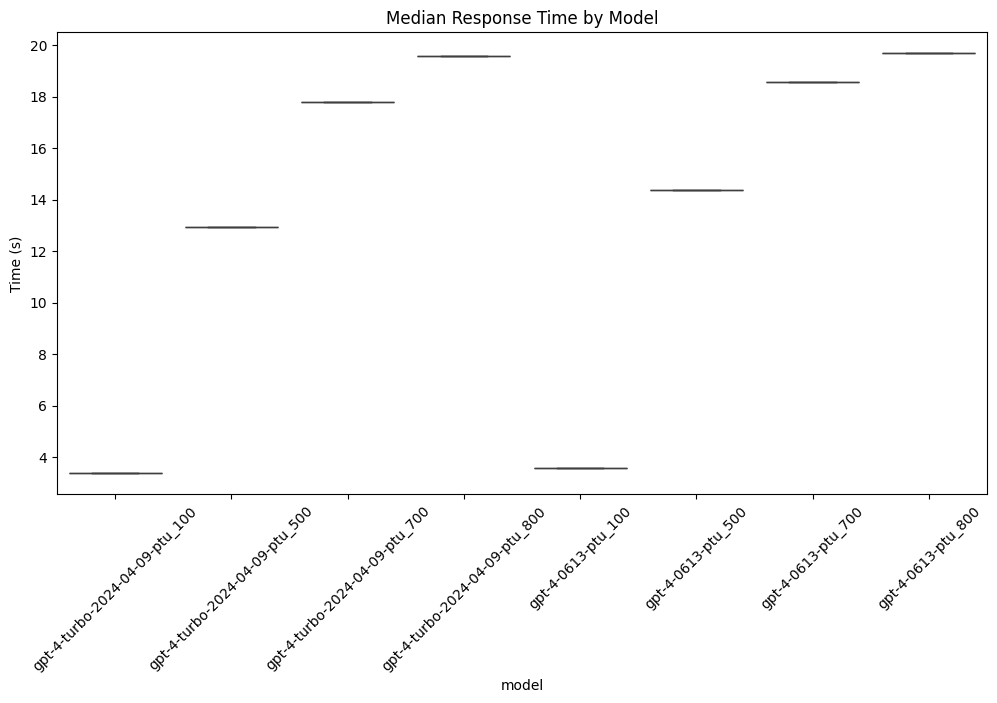

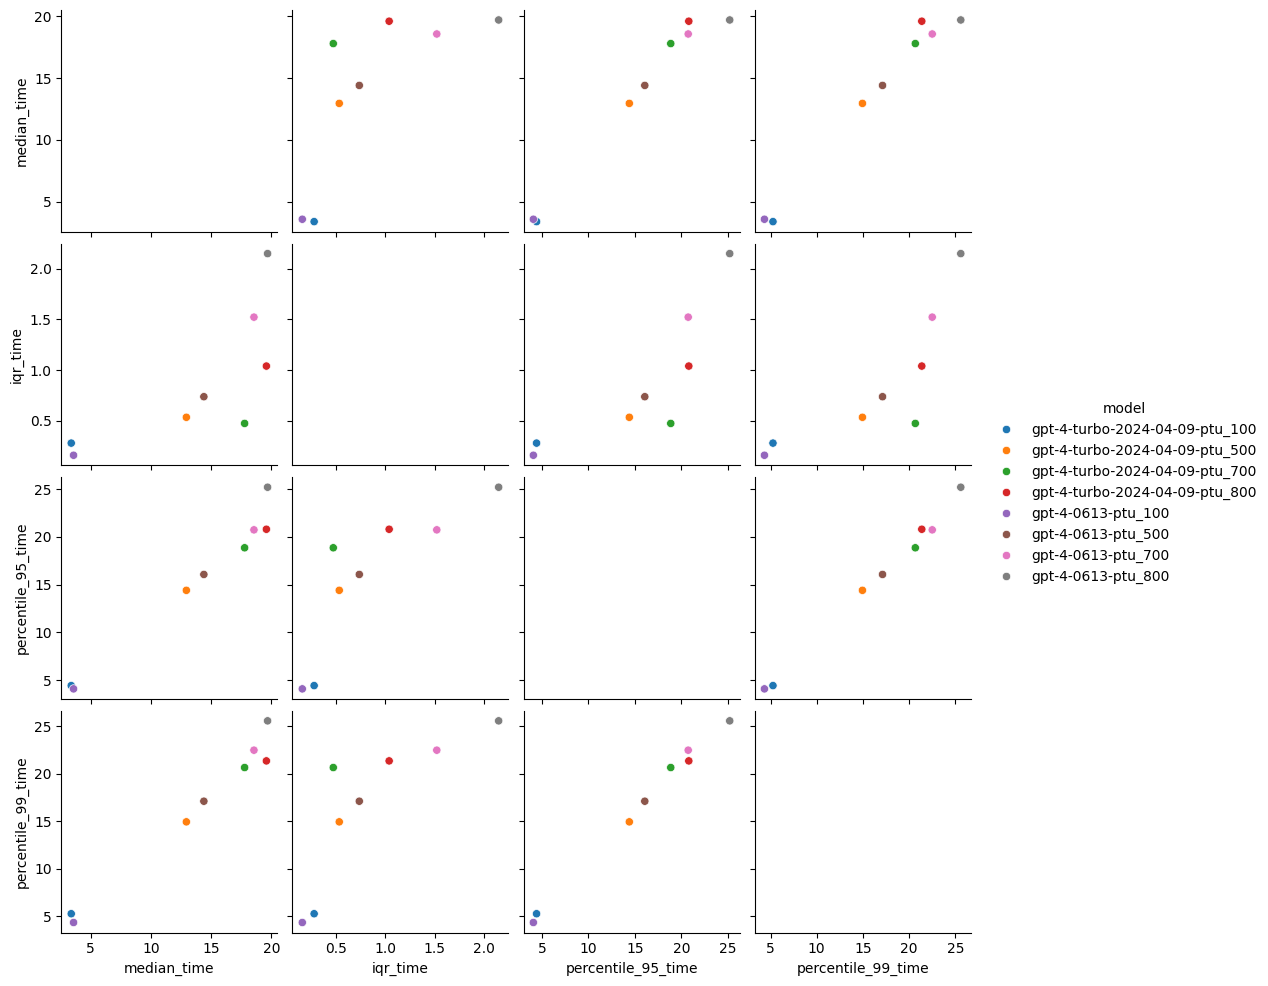

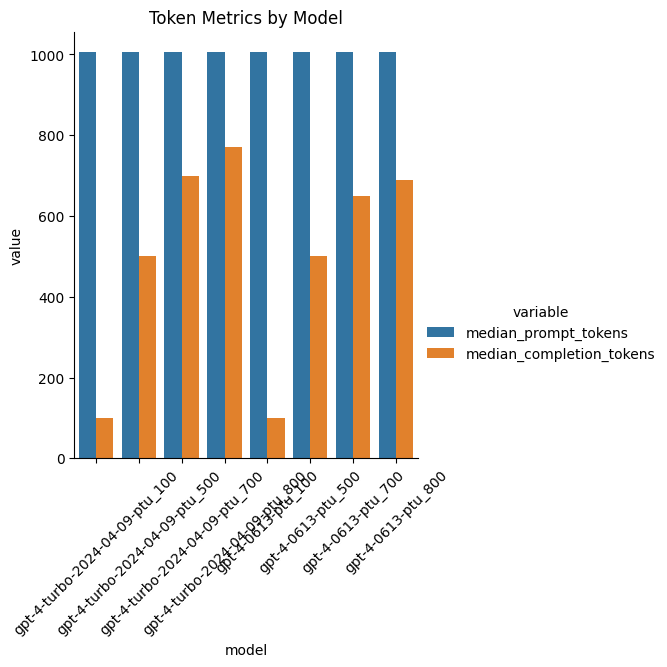

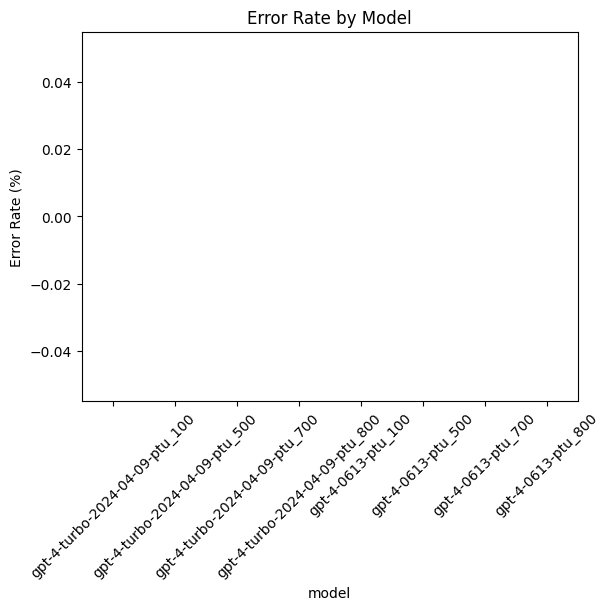

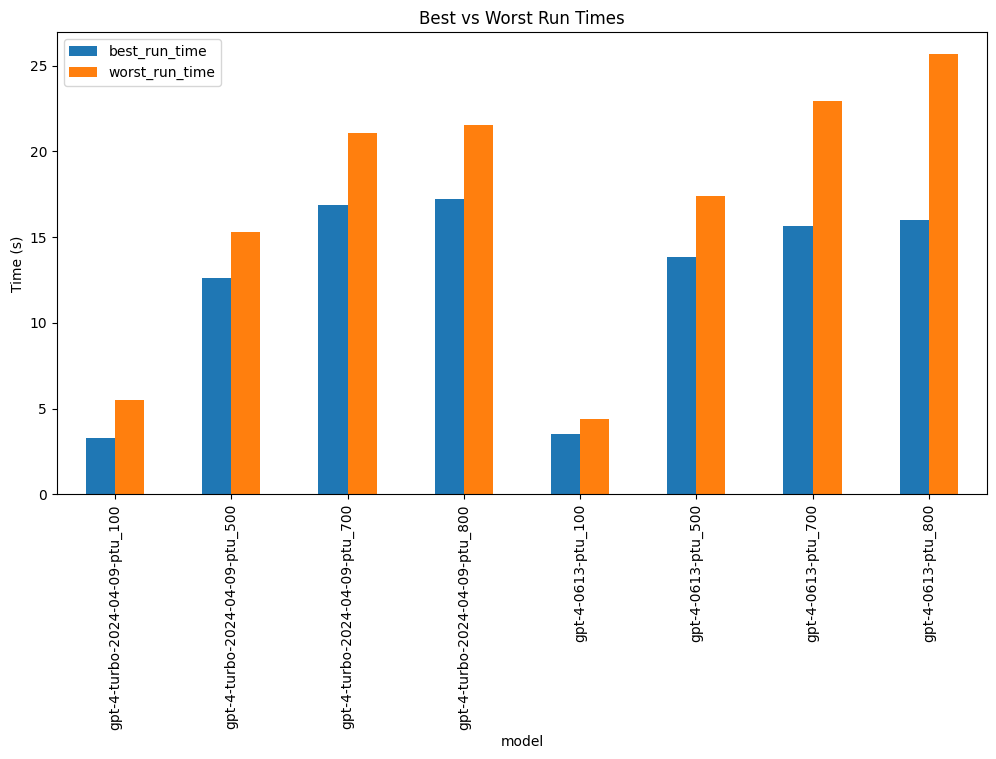

2024-05-13 22:30:56,160 - micro - MainProcess - ERROR    An error occurred while plotting the heatmap: unhashable type: 'list' (stats.py:plot_heatmaps:100)
ERROR:micro:An error occurred while plotting the heatmap: unhashable type: 'list'


<Figure size 1000x800 with 0 Axes>

In [28]:
from src.performance.aoaihelpers.stats import ModelPerformanceVisualizer

visualizer = ModelPerformanceVisualizer(data=combined_stats)
visualizer.visualize_all()